In [1]:
##Load modules and libraries
import numpy as np
import os.path
import string
import matplotlib
import matplotlib.pyplot as plt

# For my hw1 code
SEED = 1234
RNG = np.random.default_rng(SEED)
import time

# Function to generate Item memory for symbols

In [2]:
def makeItemMemory(dimension):
    alphabet = list(string.ascii_lowercase+' ') # set of used symbols 
    HDdic = {}
    for symb in alphabet:
        HDdic[symb] = 2*np.random.randint(low=0, high=2, size=dimension)-1 # assign a random bipolar HD vector 
    return HDdic

# Parameters 

In [3]:
langLabels = ['pol', 'ces', 'slk', 'slv', 'bul', 'ron', 'ita',  'por',    'spa',   'fra', 'eng', 'deu',  'nld', 'dan', 'swe', 'fin', 'hun', 'est', 'lav', 'lit', 'ell'] # Names of training files for different languages 
langFull = ['Polish', 'Czech', 'Slovak', 'Slovene','Bulgarian', 'Romanian', 'Italian',  'Portuguese',   'Spanish',   'French', 'English', 'German', 'Dutch', 'Danish', 'Swedish', 'Finnish', 'Hungarian', 'Estonian', 'Latvian', 'Lithuanian',   'Greek'] # Full names of languages 

dimension = 1024 # Dimensionality for high-dimensional vectors
n=3 # size of n-gram

dataSizeLimit=20000 # number symbols to consider for each language. If set to 0 then take full dataset

# Initialize profile vectors 

In [4]:
def initProfiles(dimension: int = dimension, langLabels: list = langLabels):    
    HDProfiles = {}
    for lang in langLabels:
        HDProfiles[lang] = np.zeros(dimension) # initialize profile vectors
    return HDProfiles

# Function to form an HD vector for a given n-gram 

In [5]:
######################
#Function from my HW1
#####################
def bind(vector1: np.array, vector2: np.array) -> np.array:
    bound_vector = vector1 * vector2
    return bound_vector

def permutation(vector1: np.array) -> np.array:
    #Using roll for consistent permutation
    permuted_vector = np.roll(vector1, 1)
    return permuted_vector

def makengramHD(seq: str, HDdic: dict, dimension: int = dimension) -> np.array:
    n=len(seq)
    HDgram=np.ones(dimension) # initialize n-gram's HD vector to all ones  
    
    #ToDo use binding and permutation operations to create n-gram's HD vector
    for letter in seq:
        letter_embedding = HDdic[letter]
        HDgram = bind(
                        letter_embedding, 
                        permutation(
                                        HDgram
                                    )
                    )

    return HDgram

# Construct HD vectors representing n-gram statistics for each language 

In [6]:
def construct_hdvec(dimension: int = dimension, n: int = n, langLabels: list = langLabels) -> dict:
    HDdic=makeItemMemory(dimension) # make item memory for the set of used symbols (26 letters  + space)
    HDProfiles=initProfiles(dimension,langLabels) # initialize profile HD vectors

    #For each language
    for lang in langLabels:
        #print (lang)
        data_file_name=os.path.abspath(os.path.join('training_texts', lang +'.txt')) # get training data

        with open(data_file_name, 'r') as f:
            langdData = f.read() # read file
        f.close()  

        # if training data should be trimmed
        if dataSizeLimit>0 and len(langdData)>dataSizeLimit: 
            langdData=langdData[0:dataSizeLimit]

        #Construct profile HD vectors
        start = time.time()
        for i in range(0,len(langdData)-n+1):
            seq=langdData[i:i+n] # pick the current n-gram
            HDgram=makengramHD(seq,HDdic, dimension) # get n-gram's HD vector
            HDProfiles[lang] += HDgram # update profile HD vector
#         print(f"Language {lang} took {time.time()- start} sec")
        
    return HDProfiles

# Compute cosine similarities between profile HD vectors

In [7]:
from typing import Tuple
def get_cossim(HDProfiles: dict, langLabels: list = langLabels, langFull: list = langFull) -> Tuple[np.array, list]:
    
    Languages=[] # full names of the lanuages in the right order
    keys=list(HDProfiles.keys()) # order of lanuages in the dictionary
    for key in keys:
        ind=langLabels.index(key)
        Languages.append(langFull[ind])

    # Get profiles HD vector into an array
    profiles=np.array(list(HDProfiles.values()))

    #ToDo calculate cosine similarity between HD vectors in "profiles"
    from sklearn.metrics.pairwise import cosine_similarity #Using because its probably faster, have my code in comments in case this is not allowed
    cos_sim = cosine_similarity(profiles)

    # rows = profiles.shape[0]
    # cos_sim = np.zeros((rows,rows))
    # for i in range(rows):
    #     for j in range(rows):
    #         cos_sim[i][j] = np.dot(rows[i], rows[i]) / (np.linalg.norm(rows[i]) * np.linalg.norm(rows[j]))
    return cos_sim, Languages

# Visualize cosine similarities

In [8]:
def plot(cos_sim: np.array, 
         languages: list, 
         title: str) -> matplotlib.pyplot.figure:
    
    plt.rcParams.update({'font.size': 9})

    fig, ax = plt.subplots(dpi=300)
    im = ax.imshow(cos_sim, cmap="inferno",vmin=0, vmax=1)

    #ToDo visualize cosine similarity between language profiles
    plt.xticks(np.arange(0, len(langLabels)), langLabels, rotation =45)
    plt.yticks(np.arange(0, len(langLabels)), langLabels)
    
    ax.set_title(title)
    fig.tight_layout()
    return fig

In [9]:
def run_experiment(dimension: int = dimension, n: int = n, 
                   title: str="Cosine similarity between language profiles") -> matplotlib.pyplot.figure:
    
    HDProfiles = construct_hdvec(dimension, n)
    cos_sim, languages = get_cossim(HDProfiles)
    plt_fig = plot(cos_sim, languages, title)
    plt.show()

## Question 1
Visualize the cosine similarities between languages’ profile HD vectors (for example, by
showing a heatmap of pairwise similarities). Are your results qualitatively similar to
Figure 1 in “Language Geometry Using Random Indexing”?

### Answer
Yes, we can see the clustering between the Slavic languages, Romanic languages, Uralic languages. 

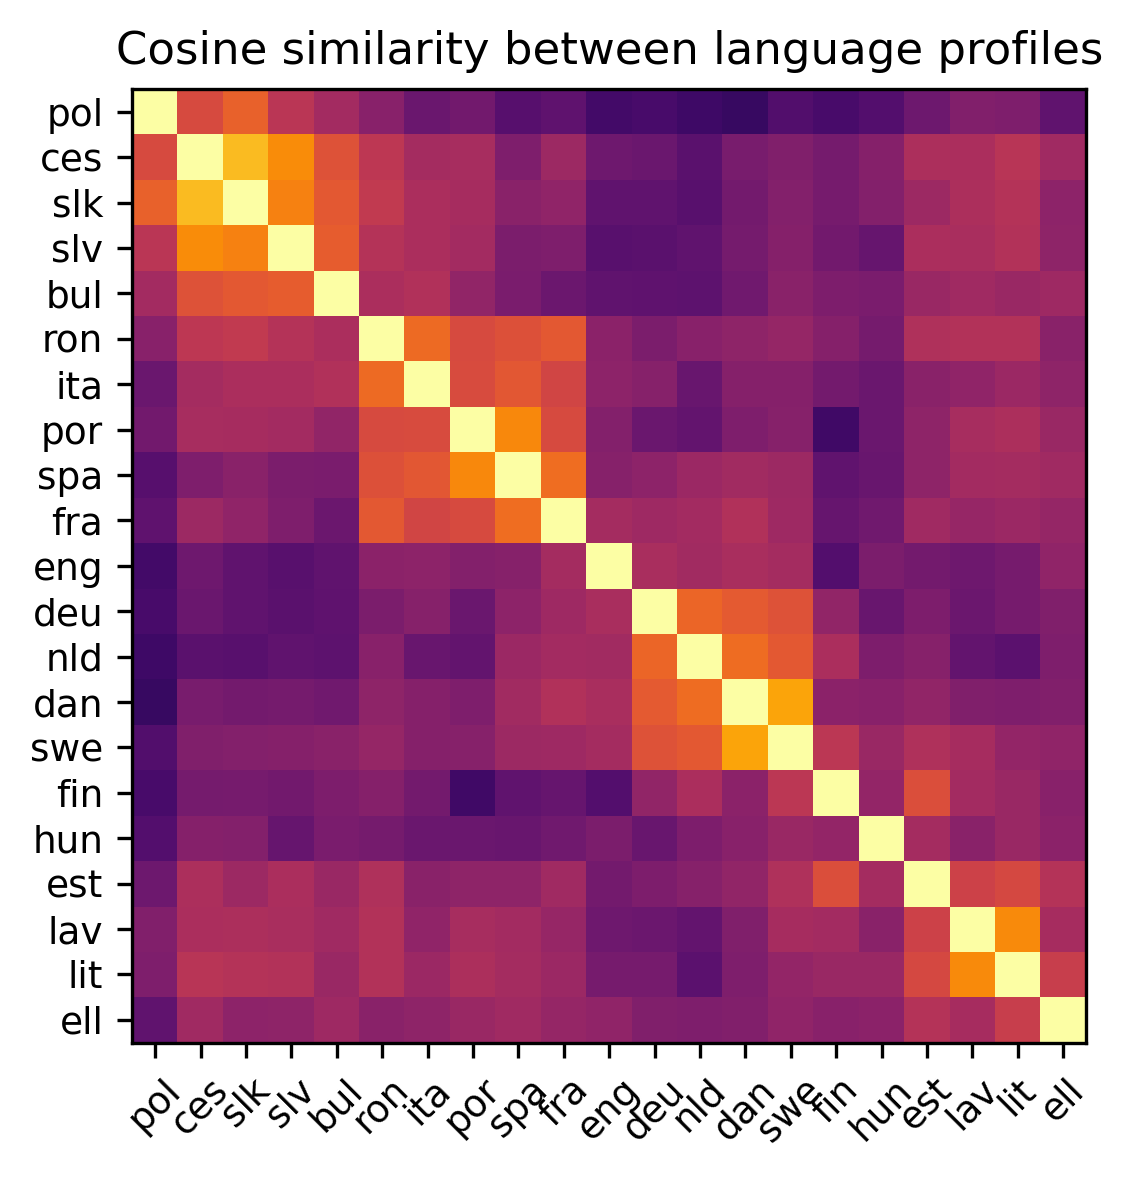

In [10]:
run_experiment()

## Question 2
By default, the size of n-grams is set to 3. How does your visualization change if you
change the value of n? What value of n seems to be optimal? What happens to cosine
similarities when n is either too small or too large?

### Answer
N of 3 seems optimal. If n is too small, every language is very similar to each other. This is because we are simply adding random vectors (there are no permutations applied, which are needed to create the notion of a sequence) to create our langauge embedding. While random vectors are orthogonal, this means that there non-zero bits (in the simple binary setting) are in non-overlapping regions. Thus, we essentially create vectors of 1s (in the binary case) when doing letter-grams. This idea extends to the case of bipolar vectors (following Pentti's paper from lec1). If n is too big, the cos similarity matrix becomes too sparse. I think is because we are comparing frequencies of larger substrings which occur less in our text corpus (especially given my data limit of 20k).

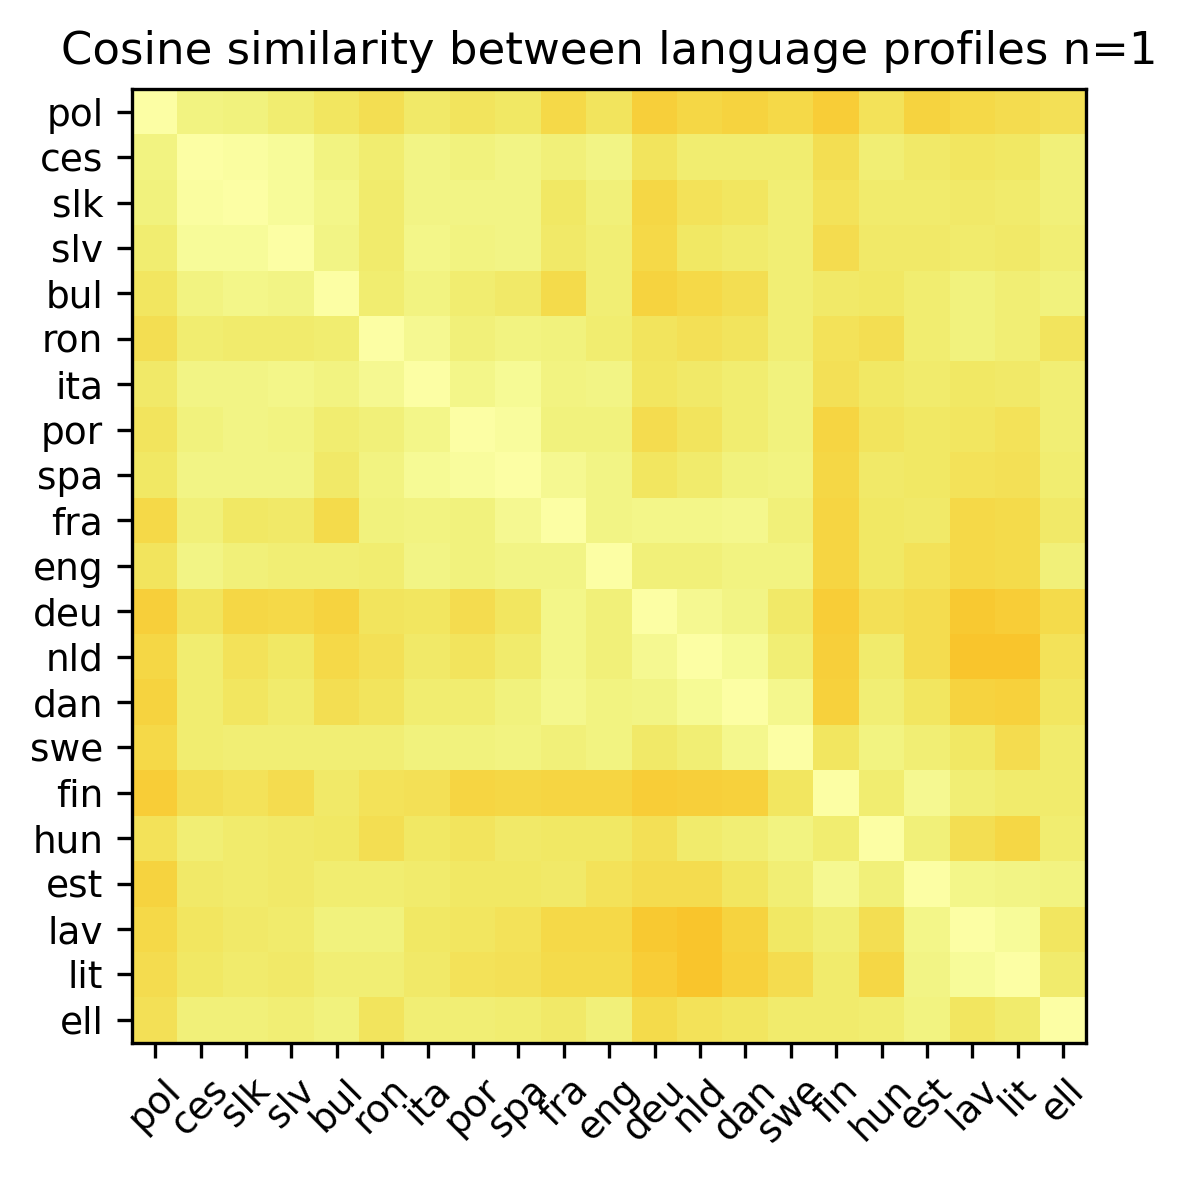

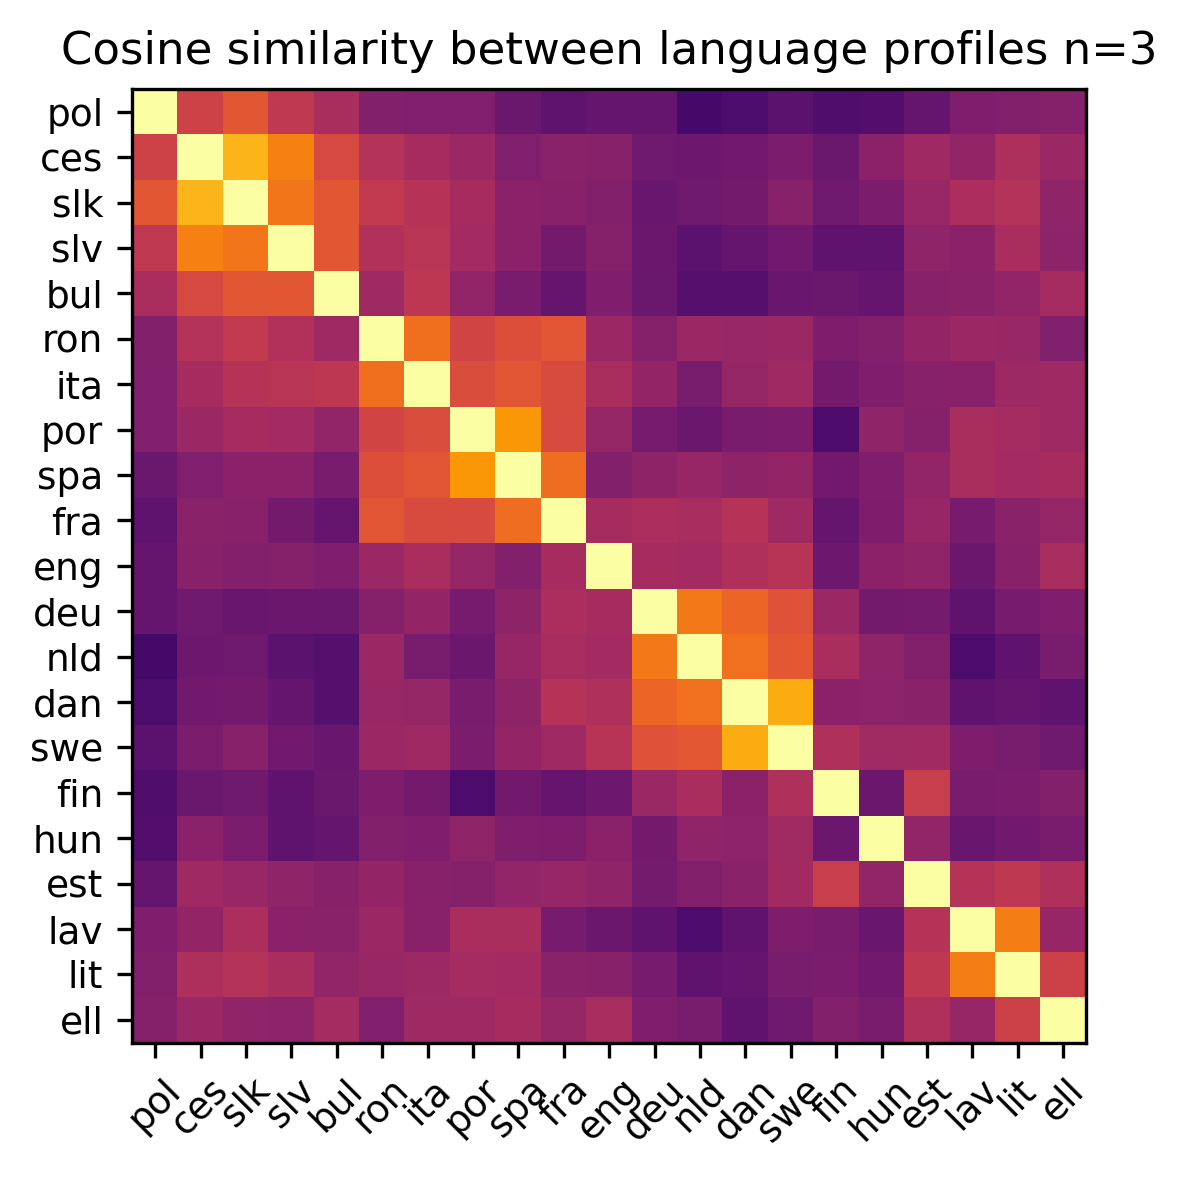

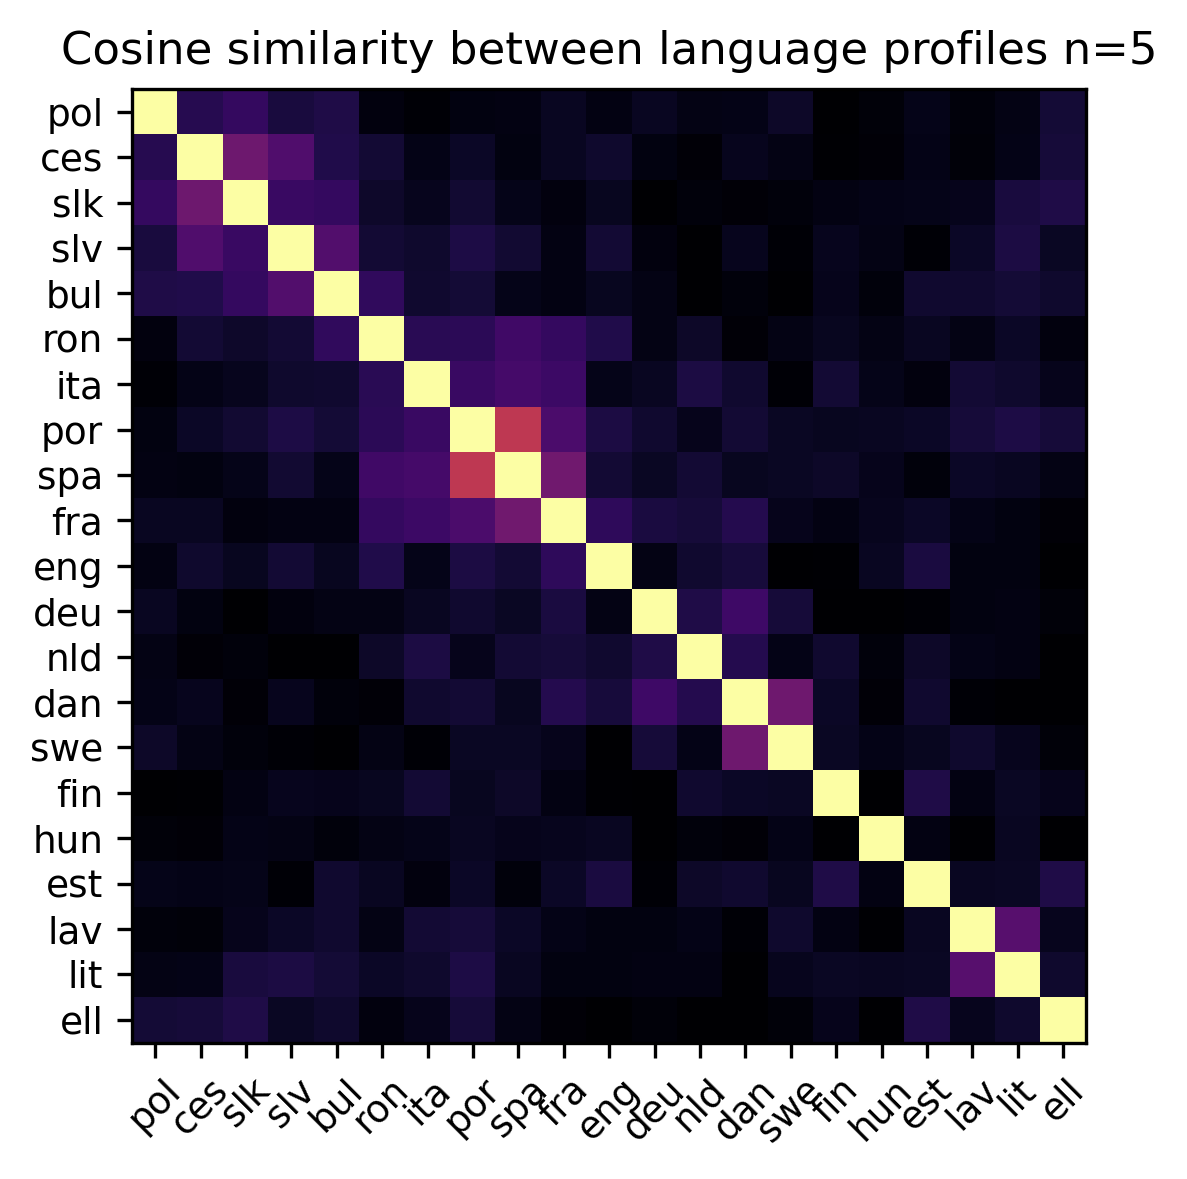

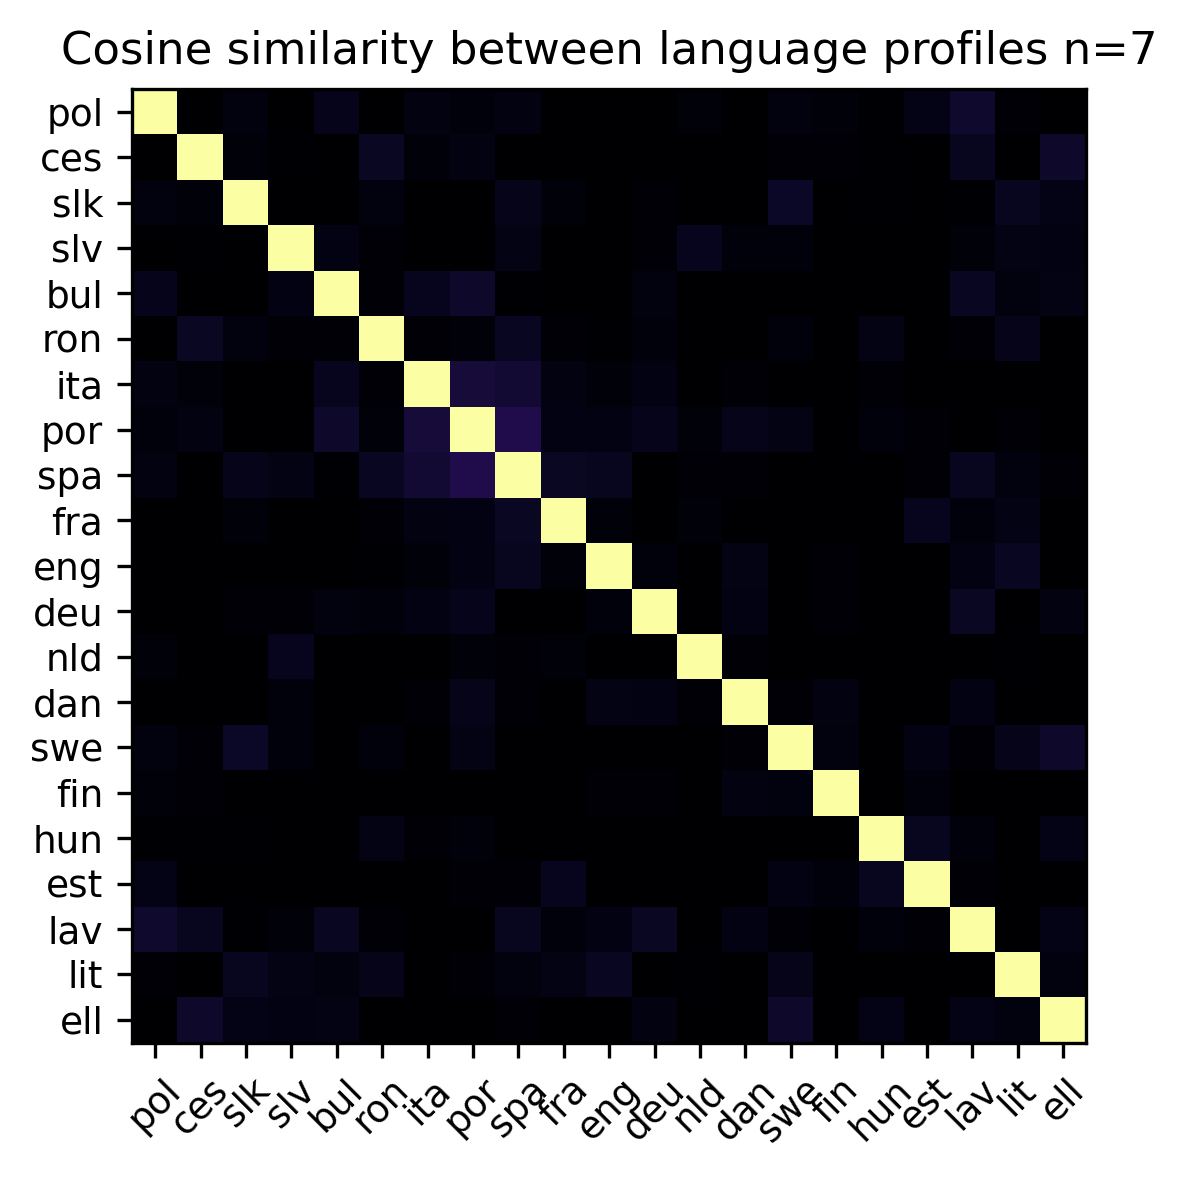

In [11]:
for n_i in [1, 3, 5,7]:
    run_experiment(n=n_i, title=f"Cosine similarity between language profiles n={n_i}")

## Question 3
By default, the dimensionality of HD vectors is set to 1,024. Is this dimensionality
enough to visualize the similarity between languages’ n-gram statistics? What happens if
the dimensionality of HD vectors is reduced dramatically?

### Answer
Yes, this dimensionality is enough. When reducing the dimensionality dramatically, we see the clustering gets worse as the matrix gets more sparse. However, some high level patterns such as similarity in Urlic languages are still seen.

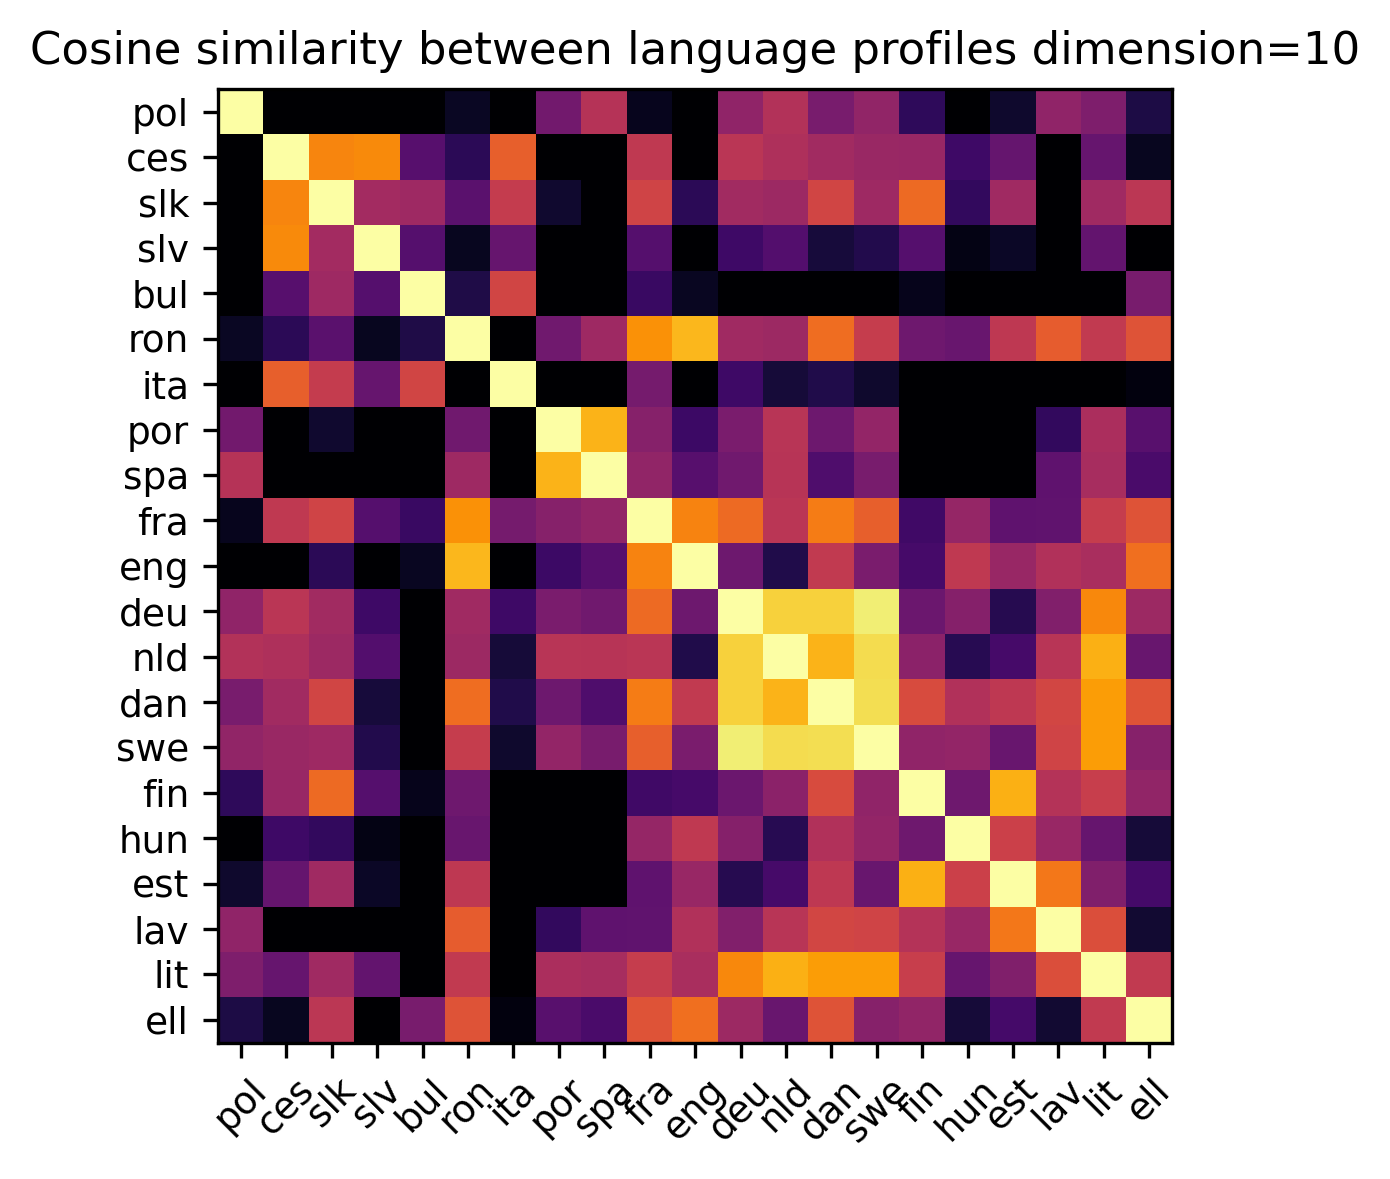

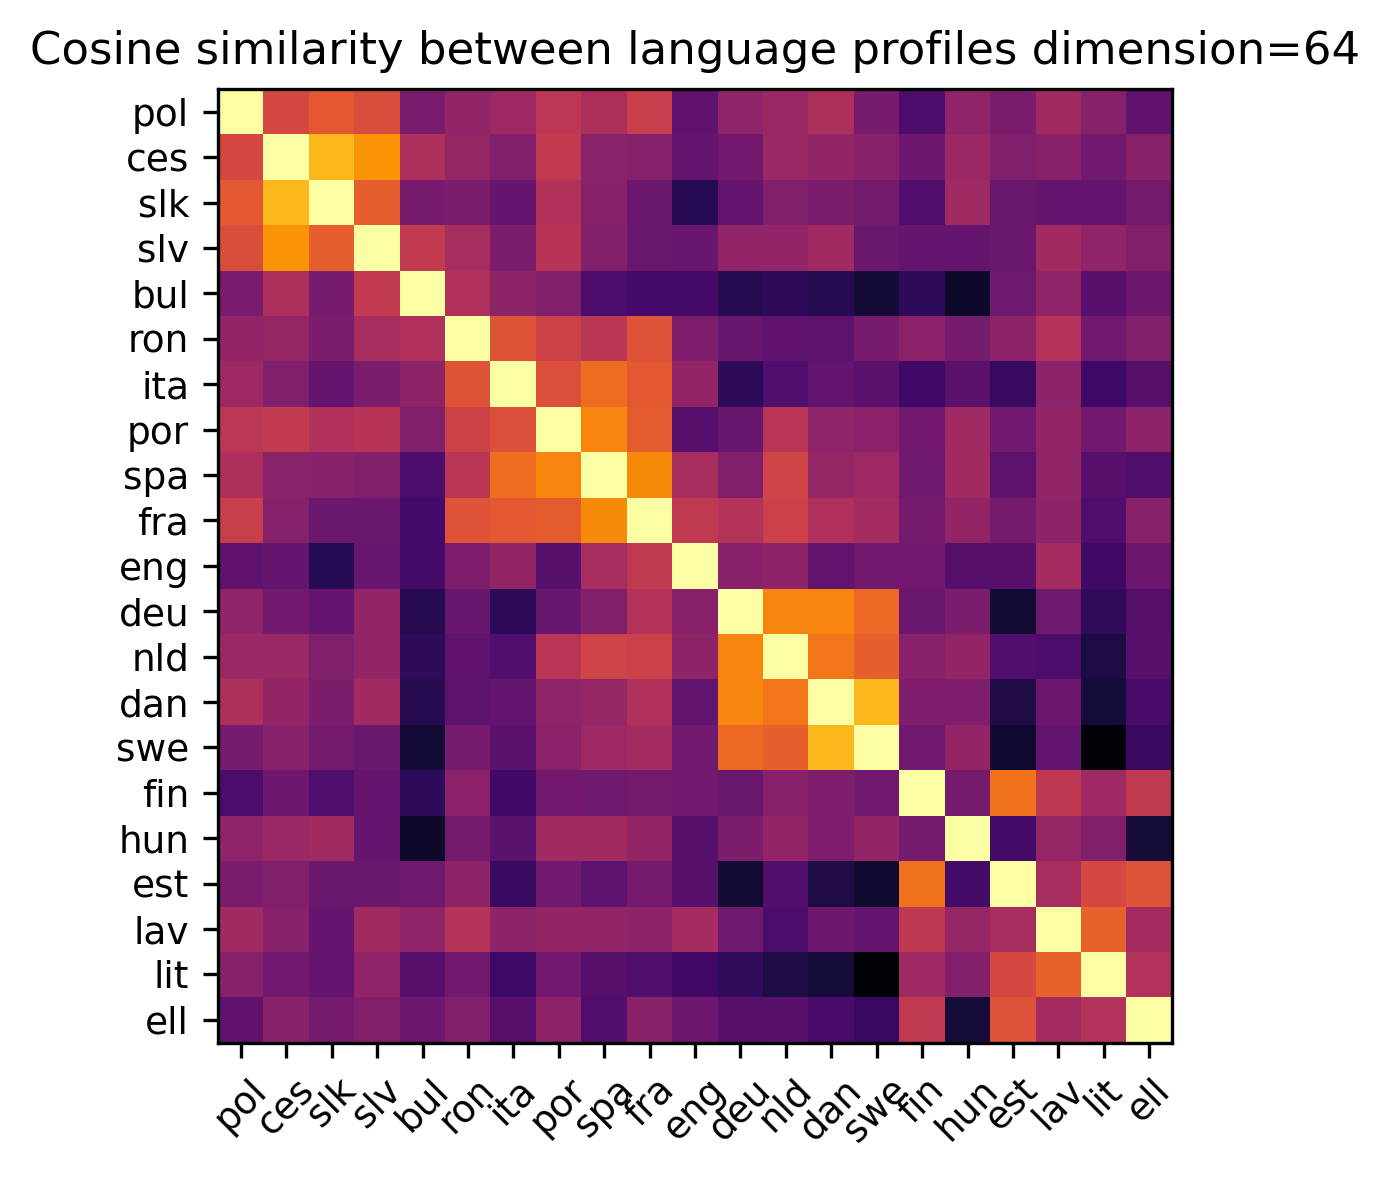

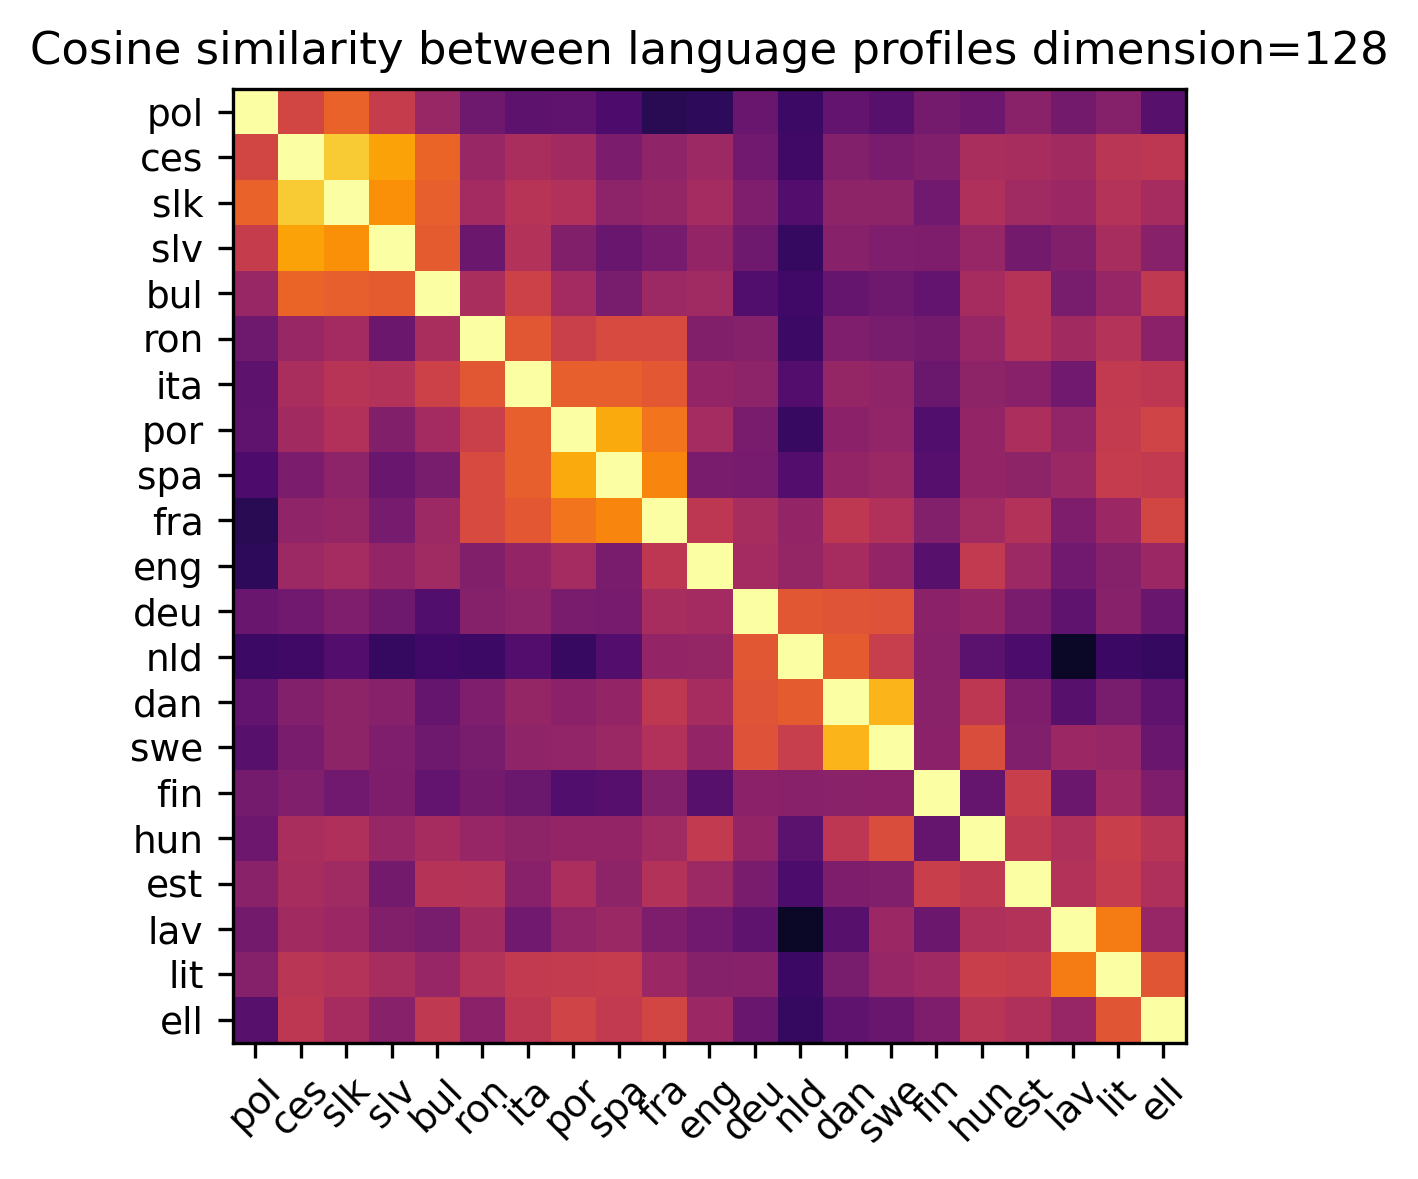

In [12]:
for dim in [10, 64, 128]:
    run_experiment(dimension=dim, title=f"Cosine similarity between language profiles dimension={dim}")